### Team

Shiref Khaled Elhalawany -  221100944

Karim Ashraf Elsayed - 221100391

Bassant Kamal Mesilam - 221100244 

# Section 3: Clustering-based Collaborative Filters
## 3.3.1. Part 1: K-means Clustering based on average number of user ratings

### Paths and Environment Setup

This part imports the required libraries, adds the project root directory to `sys.path` so shared modules can be imported, and defines the absolute paths to the `dataset` and `results` folders.  
It then prints these paths to confirm the environment is configured correctly.

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import random
import matplotlib.pyplot as plt
import math

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

dataset_folder = os.path.join(project_root, 'dataset')
results_folder = os.path.join(project_root, 'results')

print(f"Dataset folder: {dataset_folder}")
print(f"Results folder: {results_folder}")

Dataset folder: e:\University\Year 5\Semester 9\Intelligent Recommender System\Assignment\Assignment 1_V4\dataset
Results folder: e:\University\Year 5\Semester 9\Intelligent Recommender System\Assignment\Assignment 1_V4\results


### 3.3.1.1

This section loads the pre-computed **average rating per user** from:
`3_1_5_user_avgs.csv`

It verifies that the file exists, prints a sample preview of the data, and dynamically detects the correct column names for:
- **User ID column**
- **Average Rating column**

These column names will be used later in computations to ensure the script adapts even if column headers change.

In [ ]:
user_avgs_path = os.path.join(results_folder, '3_1_5_user_avgs.csv')

if os.path.exists(user_avgs_path):
    df_user_avgs = pd.read_csv(user_avgs_path)
    print("User averages loaded successfully.")
    display(df_user_avgs.head())
else:
    print(f"File not found: {user_avgs_path}")


print("Columns in df_user_avgs:", df_user_avgs.columns.tolist())

user_col = df_user_avgs.columns[0]
avg_rating_col = df_user_avgs.columns[1]

print(f"Using '{user_col}' as user column.")
print(f"Using '{avg_rating_col}' as average rating column.")

User averages loaded successfully.


,user,avg
0,A1N070NS9CJQ2I,4.0
1,A3P0KRKOBQK1KN,5.0
2,A192HO2ICJ75VU,5.0
3,A2T278FKFL3BLT,4.0
4,A2ZUXVTW8RXBXW,5.0


Columns in df_user_avgs: ['user', 'avg']
Using 'user' as user column.
Using 'avg' as average rating column.


### 3.3.1.2
Create a 1-dimensional feature vector for each user where the feature is their average rating value.

In [ ]:
avg_rating_col = df_user_avgs.columns[1]
print(f"Using column '{avg_rating_col}' as the feature.")

X = df_user_avgs[[avg_rating_col]].values

print(f"Feature vector shape: {X.shape}")
print("First 5 feature values:")
print(X[:5])

Using column 'avg' as the feature.
Feature vector shape: (9838676, 1)
First 5 feature values:
[[4.]
 [5.]
 [5.]
 [4.]
 [5.]]


### 3.3.1.3
In this step, we manually compute the **mean of the users’ average ratings** 

In [ ]:
def manual_mean(values):
    total = 0
    count = 0
    for v in values:
        total += v
        count += 1
    return total / count

avg_values = df_user_avgs[avg_rating_col].tolist()

mu = manual_mean(avg_values)
print(f"Mean of users' average ratings (μ): {mu}")

Mean of users' average ratings (μ): 3.9461489208542035


### 3.3.1.4
To better understand how user ratings vary from the mean, we manually compute the **standard deviation** of the users’ average ratings.

In [ ]:
def manual_std(values, mean):
    sum_sq = 0
    count = 0
    for v in values:
        sum_sq += (v - mean) ** 2
        count += 1
    return (sum_sq / count) ** 0.5 

sigma = manual_std(avg_values, mu)
print(f"Standard deviation of users' average ratings (σ): {sigma}")

Standard deviation of users' average ratings (σ): 1.3750508851103624


### 3.3.1.5
In this step, we standardize each user’s average rating using **Z-score normalization**.  
This transformation shows how far each user’s rating behavior is from the global mean,relative to the overall variability (standard deviation).

This helps ensure that all users contribute fairly to clustering, especially since
some users are very generous while others are more strict in their ratings.

Output saved to:  
`3_3_1_5_normalized_user_features.csv`

In [ ]:
def manual_z_score(value, mean, std):
    return (value - mean) / std

avg_values = df_user_avgs[avg_rating_col].tolist()

df_user_avgs['z_score'] = [
    manual_z_score(v, mu, sigma) for v in avg_values
]

Z = df_user_avgs[['z_score']].values

print("First 5 normalized values (z-scores):")
print(df_user_avgs[[user_col, avg_rating_col, 'z_score']].head())
print(f"Normalized feature vector shape: {Z.shape}")

output_path = os.path.join(results_folder, '3_3_1_5_normalized_user_features.csv')
df_user_avgs.to_csv(output_path, index=False)
print(f"\nNormalized user features saved successfully to:\n{output_path}")

First 5 normalized values (z-scores):
             user  avg   z_score
0  A1N070NS9CJQ2I  4.0  0.039163
1  A3P0KRKOBQK1KN  5.0  0.766409
2  A192HO2ICJ75VU  5.0  0.766409
3  A2T278FKFL3BLT  4.0  0.039163
4  A2ZUXVTW8RXBXW  5.0  0.766409
Normalized feature vector shape: (9838676, 1)

Normalized user features saved successfully to:
e:\University\Year 5\Semester 9\Intelligent Recommender System\Assignment\Assignment 1_V4\results\3_3_1_5_normalized_user_features.csv


### 3.3.1.6.1
In this step, we apply **K-Means clustering** to the 1D normalized feature (user z-scores), grouping users based on how generously or strictly they rate items.

We test different values of **K** (5, 10, 15, 20, 30, 50) to explore how the number of clusters affects the grouping.  
For each value of K:
- The algorithm iteratively assigns users to the nearest centroid.
- Centroids are recalculated as the mean of each cluster.
- The process repeats until convergence.

The final centroids (cluster centers) represent the **average strictness generosity** of each cluster.

The centroid files are saved to:  
- `3_3_1_6_1_centroids_k5.csv`  
- `3_3_1_6_1_centroids_k10.csv`  
- `3_3_1_6_1_centroids_k15.csv`  
- `3_3_1_6_1_centroids_k20.csv`  
- `3_3_1_6_1_centroids_k30.csv`  
- `3_3_1_6_1_centroids_k50.csv`

In [ ]:
def initialize_centroids_1d(values, K):
    unique_values = list(set(values))
    if len(unique_values) >= K:
        return random.sample(unique_values, K) 
    else:
        return [random.choice(values) for _ in range(K)]

In [ ]:
def assign_clusters_1d(values, centroids):
    assignments = []
    for v in values:
        min_dist = None
        best_k = None
        for k, c in enumerate(centroids):
            dist = abs(v - c)
            if (min_dist is None) or (dist < min_dist):
                min_dist = dist
                best_k = k
        assignments.append(best_k)
    return assignments

In [ ]:
def recompute_centroids_1d(values, assignments, K):
    new_centroids = []
    for k in range(K):
        cluster_vals = [v for v, a in zip(values, assignments) if a == k]
        if len(cluster_vals) == 0:
            new_centroids.append(random.choice(values))
        else:
            new_centroids.append(manual_mean(cluster_vals))
    return new_centroids

In [ ]:
def kmeans_1d(values, K, max_iters=100, tol=1e-4):
    centroids = initialize_centroids_1d(values, K)
    for iteration in range(max_iters):
        assignments = assign_clusters_1d(values, centroids)
        new_centroids = recompute_centroids_1d(values, assignments, K)
        max_shift = max(abs(c - nc) for c, nc in zip(centroids, new_centroids))
        centroids = new_centroids
        if max_shift < tol:
            break
    return centroids, assignments

In [ ]:
features = [float(v[0]) for v in Z]  

random.seed(42)

K_values = [5, 10, 15, 20, 30, 50]
k_to_assignments = {}

for K in K_values:
    centroids, assignments = kmeans_1d(features, K)
    k_to_assignments[K] = assignments  
    df_centroids = pd.DataFrame({
        'ClusterID': list(range(K)),
        'Centroid_z_score': centroids
    })
    centroid_path = os.path.join(results_folder, f'3_3_1_6_1_centroids_k{K}.csv')
    df_centroids.to_csv(centroid_path, index=False)

    print(f"K = {K}:")
    print(df_centroids.head())
    print(f"Centroids saved to: {centroid_path}\n")

K = 5:
   ClusterID  Centroid_z_score
0          0         -2.141004
1          1          0.733681
2          2          0.020222
3          3         -1.423793
4          4         -0.702770
Centroids saved to: e:\University\Year 5\Semester 9\Intelligent Recommender System\Assignment\Assignment 1_V4\results\3_3_1_6_1_centroids_k5.csv

K = 10:
   ClusterID  Centroid_z_score
0          0         -0.177856
1          1          0.260299
2          2          0.460320
3          3         -0.686781
4          4         -1.050819
Centroids saved to: e:\University\Year 5\Semester 9\Intelligent Recommender System\Assignment\Assignment 1_V4\results\3_3_1_6_1_centroids_k10.csv

K = 15:
   ClusterID  Centroid_z_score
0          0          0.399666
1          1          0.471844
2          2          0.568636
3          3         -1.044606
4          4          0.287332
Centroids saved to: e:\University\Year 5\Semester 9\Intelligent Recommender System\Assignment\Assignment 1_V4\results\3_3_1_6_

### 3.3.1.6.2
After computing the K-Means centroids, each user is assigned to the cluster whose
centroid is closest to their normalized rating behavior (z-score).

In this step, we store these assignments for all tested K values
(5, 10, 15, 20, 30, 50).

Cluster assignment files are saved to:
- `3_3_1_6_2_clusters_k5.csv`  
- `3_3_1_6_2_clusters_k10.csv`  
- `3_3_1_6_2_clusters_k15.csv`  
- `3_3_1_6_2_clusters_k20.csv`  
- `3_3_1_6_2_clusters_k30.csv`  
- `3_3_1_6_2_clusters_k50.csv`

In [ ]:
for K in K_values:
    assignments = k_to_assignments[K]

    df_clusters = pd.DataFrame({
        user_col: df_user_avgs[user_col],       
        'avg_rating': df_user_avgs[avg_rating_col],
        'z_score': df_user_avgs['z_score'],
        'ClusterID': assignments
    })

    cluster_path = os.path.join(results_folder, f'3_3_1_6_2_clusters_k{K}.csv')
    df_clusters.to_csv(cluster_path, index=False)

    print(f"K = {K}: cluster assignments saved to: {cluster_path}")
    print(df_clusters.head(), "\n")

K = 5: cluster assignments saved to: e:\University\Year 5\Semester 9\Intelligent Recommender System\Assignment\Assignment 1_V4\results\3_3_1_6_2_clusters_k5.csv
             user  avg_rating   z_score  ClusterID
0  A1N070NS9CJQ2I         4.0  0.039163          2
1  A3P0KRKOBQK1KN         5.0  0.766409          1
2  A192HO2ICJ75VU         5.0  0.766409          1
3  A2T278FKFL3BLT         4.0  0.039163          2
4  A2ZUXVTW8RXBXW         5.0  0.766409          1 

K = 10: cluster assignments saved to: e:\University\Year 5\Semester 9\Intelligent Recommender System\Assignment\Assignment 1_V4\results\3_3_1_6_2_clusters_k10.csv
             user  avg_rating   z_score  ClusterID
0  A1N070NS9CJQ2I         4.0  0.039163          7
1  A3P0KRKOBQK1KN         5.0  0.766409          5
2  A192HO2ICJ75VU         5.0  0.766409          5
3  A2T278FKFL3BLT         4.0  0.039163          7
4  A2ZUXVTW8RXBXW         5.0  0.766409          5 

K = 15: cluster assignments saved to: e:\University\Year 5\S

### 3.3.1.7.1
After clustering users based on their normalized average ratings (z-scores), we count how many users fall into each cluster for every tested value of **K** 
(5, 10, 15, 20, 30, 50).

In [ ]:
cluster_sizes_results = {}

for K in K_values:
    assignments = k_to_assignments[K]
    counts = {c: 0 for c in range(K)}
    
    for a in assignments:
        counts[a] += 1

    cluster_sizes_results[K] = counts

    print(f"\nK = {K} cluster sizes:")
    for cluster_id, size in counts.items():
        print(f"  Cluster {cluster_id}: {size} users")


K = 5 cluster sizes:
  Cluster 0: 1155377 users
  Cluster 1: 5285161 users
  Cluster 2: 1911109 users
  Cluster 3: 551387 users
  Cluster 4: 935642 users

K = 10 cluster sizes:
  Cluster 0: 184433 users
  Cluster 1: 264117 users
  Cluster 2: 540185 users
  Cluster 3: 729689 users
  Cluster 4: 157122 users
  Cluster 5: 4748831 users
  Cluster 6: 1155377 users
  Cluster 7: 1302632 users
  Cluster 8: 246677 users
  Cluster 9: 509613 users

K = 15 cluster sizes:
  Cluster 0: 311656 users
  Cluster 1: 60184 users
  Cluster 2: 243739 users
  Cluster 3: 151955 users
  Cluster 4: 151752 users
  Cluster 5: 11728 users
  Cluster 6: 382003 users
  Cluster 7: 1312543 users
  Cluster 8: 2821 users
  Cluster 9: 747864 users
  Cluster 10: 1147972 users
  Cluster 11: 467032 users
  Cluster 12: 4691186 users
  Cluster 13: 40604 users
  Cluster 14: 115637 users

K = 20 cluster sizes:
  Cluster 0: 1741 users
  Cluster 1: 171364 users
  Cluster 2: 6157 users
  Cluster 3: 460612 users
  Cluster 4: 15142 u

### 3.3.1.7.2
To evaluate the quality of clustering for different values of **K**, we compute the **Within-Cluster Sum of Squares (WCSS)** manually.

WCSS measures how tightly the users’ normalized rating values (z-scores) are grouped around their assigned cluster centroids. Lower WCSS means users inside each cluster are more similar to each other.


In [ ]:
def manual_wcss(values, assignments, centroids):
    total_wcss = 0
    for v, cluster_id in zip(values, assignments):
        c = centroids[cluster_id]
        total_wcss += (v - c) ** 2
    return total_wcss

In [ ]:
wcss_values = {}

for K in K_values:
    assignments = k_to_assignments[K]

    centroid_path = os.path.join(results_folder, f'3_3_1_6_1_centroids_k{K}.csv')
    df_c = pd.read_csv(centroid_path)
    centroids = df_c['Centroid_z_score'].tolist()

    wcss = manual_wcss(features, assignments, centroids)

    wcss_values[K] = wcss

    print(f"K = {K}, WCSS = {wcss}")

K = 5, WCSS = 116958.45948082468
K = 10, WCSS = 13268.999817422377
K = 15, WCSS = 7607.932468505355
K = 20, WCSS = 5443.175685019605
K = 30, WCSS = 1045.982044559923
K = 50, WCSS = 472.72955430783503


### 3.3.1.7.3

In this step, we visualize how the **Within-Cluster Sum of Squares (WCSS)** changes as the number of clusters **K** increases.

We plot an **Elbow Curve** where:
- The x-axis represents different K values tested (5, 10, 15, 20, 30, 50)
- The y-axis shows their corresponding WCSS values

The goal is to identify the **elbow point** — a value of K after which the reduction in WCSS becomes much smaller.

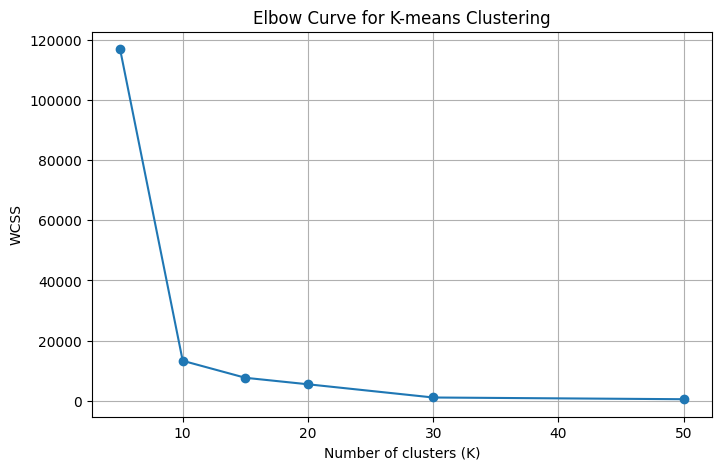

In [ ]:
Ks = list(wcss_values.keys())
WCSS = list(wcss_values.values())

plt.figure(figsize=(8,5))
plt.plot(Ks, WCSS, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Curve for K-means Clustering")
plt.grid(True)
plt.show()

### 3.3.1.7.4
After applying K-means clustering for different values of K, we now evaluate the **quality of each clustering result** using the **Silhouette Score**.

The Silhouette Score measures how well each user fits within their assigned cluster
compared to other clusters. 

In [ ]:
def silhouette_score_1d(values, assignments, K):
    scores = []

    for i in range(len(values)):
        x_i = values[i]
        cluster_i = assignments[i]

        same_cluster = []
        for j in range(len(values)):
            if i != j and assignments[j] == cluster_i:
                same_cluster.append(values[j])

        if len(same_cluster) == 0:
            continue

        total_distance_same = 0
        for x_j in same_cluster:
            total_distance_same += abs(x_i - x_j)

        a_i = total_distance_same / len(same_cluster)

        b_i_list = []

        for c in range(K):
            if c == cluster_i:
                continue

            other_cluster = []
            for j in range(len(values)):
                if assignments[j] == c:
                    other_cluster.append(values[j])

            if len(other_cluster) == 0:
                continue

            total_distance_other = 0
            for x_j in other_cluster:
                total_distance_other += abs(x_i - x_j)

            avg_dist_other = total_distance_other / len(other_cluster)
            b_i_list.append(avg_dist_other)

        if len(b_i_list) == 0:
            continue

        b_i = b_i_list[0]
        for val in b_i_list:
            if val < b_i:
                b_i = val

        if a_i > b_i:
            s_i = (b_i - a_i) / a_i
        else:
            s_i = (b_i - a_i) / b_i

        scores.append(s_i)

    if len(scores) == 0:
        return 0

    return manual_mean(scores)

In [ ]:
silhouette_results = {}

for K in K_values:
    score = silhouette_score_1d(features, k_to_assignments[K], K)
    silhouette_results[K] = score
    print(f"K = {K}, Silhouette Score = {score}")

### 3.3.1.8.1
Based on the Elbow Method and Silhouette Score analysis, the optimal number of clusters was identified as **K = 10**.

In this step, we examine how users are distributed across these 10 clusters.
This helps us understand whether the clusters are **balanced** or if some clusters
contain significantly more users (dominant preference groups).

Cluster sizes for best_K =  10
Cluster 0: 184433 users
Cluster 1: 264117 users
Cluster 2: 540185 users
Cluster 3: 729689 users
Cluster 4: 157122 users
Cluster 5: 4748831 users
Cluster 6: 1155377 users
Cluster 7: 1302632 users
Cluster 8: 246677 users
Cluster 9: 509613 users


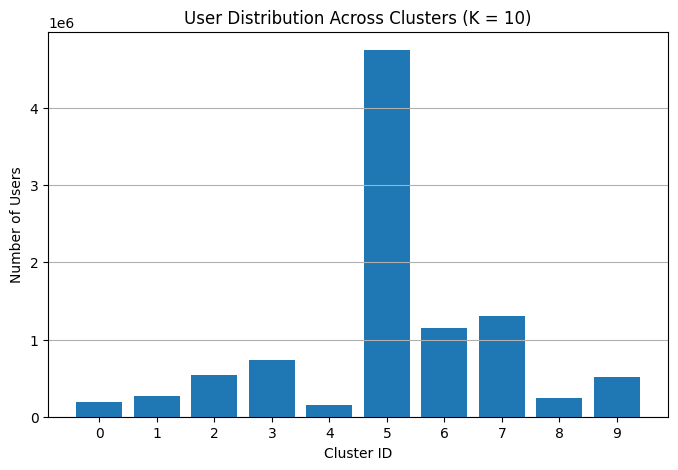

In [ ]:
best_K = 10 

assignments_best = k_to_assignments[best_K]

cluster_counts = {}
for c in range(best_K):
    cluster_counts[c] = 0

for a in assignments_best:
    cluster_counts[a] += 1

print("Cluster sizes for best_K = ", best_K)
for cid in range(best_K):
    print(f"Cluster {cid}: {cluster_counts[cid]} users")

cluster_ids = list(cluster_counts.keys())
sizes = [cluster_counts[cid] for cid in cluster_ids]

plt.figure(figsize=(8,5))
plt.bar(cluster_ids, sizes)
plt.xlabel("Cluster ID")
plt.ylabel("Number of Users")
plt.title(f"User Distribution Across Clusters (K = {best_K})")
plt.xticks(cluster_ids)
plt.grid(axis='y')
plt.show()

### 3.3.1.8.2

Each cluster is represented by a **centroid**, which reflects the average rating behavior of users in that group.
Initially, the clustering was performed on **normalized z-scores**, so here we convert each centroid back into the **original rating scale (1–5)** using the formula:

Centroid Rating = μ + (z-score × σ)

This step allows us to understand the rating behavior associated with each cluster, including:
- **Generous raters** → clusters with high average ratings  
- **Strict raters** → clusters with low average ratings  
- **Neutral / balanced raters** → clusters around the dataset mean

In [ ]:
centroid_path_best = os.path.join(results_folder, f'3_3_1_6_1_centroids_k{best_K}.csv')
df_centroids_best = pd.read_csv(centroid_path_best)

centroid_z_scores = df_centroids_best['Centroid_z_score'].tolist()
centroid_ids = df_centroids_best['ClusterID'].tolist()

centroid_avg_ratings = []
for z in centroid_z_scores:
    r_bar = mu + z * sigma
    centroid_avg_ratings.append(r_bar)

df_cluster_summary = pd.DataFrame({
    'ClusterID': centroid_ids,
    'Centroid_z_score': centroid_z_scores,
    'Centroid_avg_rating': centroid_avg_ratings
})

print("Cluster centroids (in z-score and original rating scale):")
print(df_cluster_summary)

cluster_summary_path = os.path.join(results_folder, f'3_3_1_8_2_cluster_centroids_k{best_K}.csv')
df_cluster_summary.to_csv(cluster_summary_path, index=False)
print(f"\nCluster centroid summary saved to:\n{cluster_summary_path}")

Cluster centroids (in z-score and original rating scale):
   ClusterID  Centroid_z_score  Centroid_avg_rating
0          0         -0.177856             3.701587
1          1          0.260299             4.304073
2          2          0.460320             4.579113
3          3         -0.686781             3.001789
4          4         -1.050819             2.501219
5          5          0.764480             4.997348
6          6         -2.141004             1.002159
7          7          0.039604             4.000607
8          8         -0.368080             3.440020
9          9         -1.443986             1.960595

Cluster centroid summary saved to:
e:\University\Year 5\Semester 9\Intelligent Recommender System\Assignment\Assignment 1_V4\results\3_3_1_8_2_cluster_centroids_k10.csv


### 3.3.1.8.3

To better understand the behavior within each cluster, we compare their centroid average ratings with the **global mean** of all users’ average ratings (μ).

- If a cluster’s centroid rating is **greater than μ**, the users in that cluster tend to be **more generous** — assigning higher ratings to items.
- If a cluster’s centroid rating is **less than μ**, the users in that cluster are **strict raters** — giving lower scores on average.

This classification helps us distinguish different types of users in the recommendation system:
- **Generous raters** may inflate similarity,
- **Strict raters** may deflate ratings,
- Understanding this allows **more accurate and personalized recommendation modeling**.

In [ ]:
generous_clusters = []
strict_clusters = []

for idx in range(len(df_cluster_summary)):
    cid = int(df_cluster_summary.loc[idx, 'ClusterID'])
    c_avg = float(df_cluster_summary.loc[idx, 'Centroid_avg_rating'])

    if c_avg > mu:
        generous_clusters.append((cid, c_avg))
    elif c_avg < mu:
        strict_clusters.append((cid, c_avg))

print(f"Global mean of user average ratings (μ): {mu}\n")

print("Generous rater clusters (centroid avg rating > μ):")
for cid, c_avg in generous_clusters:
    print(f"  Cluster {cid}: centroid avg rating = {c_avg}")

print("\nStrict rater clusters (centroid avg rating < μ):")
for cid, c_avg in strict_clusters:
    print(f"  Cluster {cid}: centroid avg rating = {c_avg}")


Global mean of user average ratings (μ): 3.9461489208542035

Generous rater clusters (centroid avg rating > μ):
  Cluster 1: centroid avg rating = 4.304072854076408
  Cluster 2: centroid avg rating = 4.5791129705587945
  Cluster 5: centroid avg rating = 4.997348016810374
  Cluster 7: centroid avg rating = 4.000606733137971

Strict rater clusters (centroid avg rating < μ):
  Cluster 0: centroid avg rating = 3.701587188844081
  Cluster 3: centroid avg rating = 3.001789461006796
  Cluster 4: centroid avg rating = 2.5012193709361163
  Cluster 6: centroid avg rating = 1.0021590009702503
  Cluster 8: centroid avg rating = 3.440020431578114
  Cluster 9: centroid avg rating = 1.9605949024149207


## 3.3.1.9 Apply user-based collaborative filtering within each cluster

In this step, we begin integrating the earlier clustering results with the
collaborative filtering workflow.

After identifying user clusters (K = 10 as the optimal value), we now:

1️- **Load the target users** selected earlier  
    – Loaded from: `3_1_11_selected_users.csv`

2️- **Load the target items**  
    – Loaded from: `3_1_12_selected_items.csv`

3️- **Load the cluster assignments** for K = 10   
    – Loaded from: `3_3_1_6_2_clusters_k10.csv`

4️- **Load the full ratings dataset** and build a **user → item → rating** lookup structure  

In [ ]:
target_users_path = os.path.join(results_folder, '3_1_11_selected_users.csv')
df_target_users = pd.read_csv(target_users_path)
print("Target users file columns:", df_target_users.columns.tolist())
target_user_col_3_1_11 = df_target_users.columns[0]
target_users_list = df_target_users[target_user_col_3_1_11].tolist()
print(f"Loaded {len(target_users_list)} target users from column '{target_user_col_3_1_11}'.")

target_items_path = os.path.join(results_folder, '3_1_12_selected_items.csv')
df_target_items = pd.read_csv(target_items_path)
print("Target items file columns:", df_target_items.columns.tolist())
target_item_col_3_1_12 = df_target_items.columns[0]
target_items_list = df_target_items[target_item_col_3_1_12].tolist()
print(f"Loaded {len(target_items_list)} target items from column '{target_item_col_3_1_12}'.")

cluster_path_best = os.path.join(results_folder, f'3_3_1_6_2_clusters_k{best_K}.csv')
df_clusters_best = pd.read_csv(cluster_path_best)
print(f"Loaded cluster assignments for K={best_K}.")
print(df_clusters_best.head())

ratings_file = os.path.join(dataset_folder, 'Electronics.csv')
print("Loading full ratings data (this might take a moment)...")

df_ratings = pd.read_csv(
    ratings_file,
    header=None,
    names=["ItemID", "UserID", "Rating", "Timestamp"]
)
print(f"Loaded {len(df_ratings)} ratings.")

user_item_ratings = {}
for _, row in df_ratings.iterrows():
    user = row['UserID']
    item = row['ItemID']
    rating = float(row['Rating'])
    
    if user not in user_item_ratings:
        user_item_ratings[user] = {}
    user_item_ratings[user][item] = rating

print("Ratings dictionary created.")

Target users file columns: ['UserID', 'Ratings', 'Percentage']
Loaded 3 target users from column 'UserID'.
Target items file columns: ['ItemID', 'AvgRating', 'NumRatings']
Loaded 2 target items from column 'ItemID'.
Loaded cluster assignments for K=10.
             user  avg_rating   z_score  ClusterID
0  A1N070NS9CJQ2I         4.0  0.039163          7
1  A3P0KRKOBQK1KN         5.0  0.766409          5
2  A192HO2ICJ75VU         5.0  0.766409          5
3  A2T278FKFL3BLT         4.0  0.039163          7
4  A2ZUXVTW8RXBXW         5.0  0.766409          5
Loading full ratings data (this might take a moment)...
Loaded 20994353 ratings.
Ratings dictionary created.


### Helper Functions for User-Based CF (Mean-Centered Cosine)

In [ ]:
def compute_user_means(user_ratings):
    user_means = {}
    for user, items in user_ratings.items():
        if len(items) > 0:
            user_means[user] = sum(items.values()) / len(items)
        else:
            user_means[user] = 0.0
    return user_means

def compute_rating_deviations(user_ratings, user_means):
    deviations = {}
    for user, items in user_ratings.items():
        mean = user_means[user]
        deviations[user] = {
            item: (rating - mean) for item, rating in items.items()
        }
    return deviations

def calculate_mean_centered_cosine_similarity(user1, user2, deviations):
    u1_items = deviations.get(user1, {})
    u2_items = deviations.get(user2, {})
    
    common_items = set(u1_items.keys()) & set(u2_items.keys())
    if not common_items:
        return 0.0, 0
    
    dot = 0.0
    norm1 = 0.0
    norm2 = 0.0
    
    for item in common_items:
        d1 = u1_items[item]
        d2 = u2_items[item]
        dot += d1 * d2
        norm1 += d1 ** 2
        norm2 += d2 ** 2
        
    norm1 = norm1 ** 0.5
    norm2 = norm2 ** 0.5
    
    if norm1 == 0 or norm2 == 0:
        return 0.0, len(common_items)
        
    similarity = dot / (norm1 * norm2)
    return similarity, len(common_items)

def get_top_n_similar_users_cluster(similarities_list, n_percentage=0.20):
    similarities_list.sort(key=lambda x: x['Similarity'], reverse=True)
    
    n_top = math.ceil(len(similarities_list) * n_percentage)
    return similarities_list[:n_top]

def predict_rating_cluster(target_user, item, top_neighbors, user_item_ratings):
    numerator = 0.0
    denominator = 0.0
    
    for neighbor_info in top_neighbors:
        other_user = neighbor_info['OtherUser']
        similarity = neighbor_info['Similarity']
        
        rating = user_item_ratings.get(other_user, {}).get(item)
        
        if rating is not None:
            numerator += similarity * rating
            denominator += abs(similarity)
            
    if denominator > 0:
        return numerator / denominator
    else:
        return None

def predict_ratings(df_top_users, user_item_ratings, sim_col='Similarity'):
    predictions = []

    for target_user, group in df_top_users.groupby('TargetUser'):
        target_user_items = set(user_item_ratings.get(target_user, {}).keys())
        
        candidate_items = set()
        for _, row in group.iterrows():
            other_user = row['OtherUser']
            other_user_items = user_item_ratings.get(other_user, {}).keys()
            candidate_items.update(other_user_items)
        
        unknown_items = candidate_items - target_user_items
        
        for item in unknown_items:
            numerator = 0.0
            denominator = 0.0
            
            for _, row in group.iterrows():
                other_user = row['OtherUser']
                
                similarity = row[sim_col]
                
                rating = user_item_ratings.get(other_user, {}).get(item)
                
                if rating is not None:
                    numerator += similarity * rating
                    denominator += abs(similarity)
            
            if denominator > 0:
                predicted_rating = numerator / denominator
                predictions.append({
                    'TargetUser': target_user,
                    'Item': item,
                    'PredictedRating': round(predicted_rating, 2),
                    'SimilarityType': sim_col
                })
                
    return pd.DataFrame(predictions)

### 3.3.1.9.1 

In this step, we prepare similarity calculations for the cluster-based
collaborative filtering:

1️⃣ **Compute each user’s mean rating**  

2️⃣ **Compute rating deviations**  

3️⃣ **Map each target user to their assigned cluster**  

The mapping of target users to their cluster IDs is saved to:  
`3_3_1_9_1_target_users_clusters.csv`

In [ ]:
print("Precomputing user means and deviations...")
user_means = compute_user_means(user_item_ratings)
deviations = compute_rating_deviations(user_item_ratings, user_means)
print("Precomputation complete.")

target_user_clusters = []

for target_user in target_users_list:
    user_cluster_row = df_clusters_best[df_clusters_best[user_col] == target_user]
    if user_cluster_row.empty:
        print(f"Target user {target_user} not found in cluster assignments.")
        continue

    cluster_id = int(user_cluster_row.iloc[0]['ClusterID'])
    print(f"Target User {target_user} is in Cluster {cluster_id}")
    
    target_user_clusters.append({
        'TargetUser': target_user,
        'ClusterID': cluster_id
    })

df_target_user_clusters = pd.DataFrame(target_user_clusters)

tu_cluster_path = os.path.join(results_folder, '3_3_1_9_1_target_users_clusters.csv')
df_target_user_clusters.to_csv(tu_cluster_path, index=False)

print(f"\nTarget users & clusters saved to:\n{tu_cluster_path}")
print(df_target_user_clusters)

Precomputing user means and deviations...
Precomputation complete.
Target User A1ER5AYS3FQ9O3 is in Cluster 1
Target user nan not found in cluster assignments.
Target user nan not found in cluster assignments.

Target users & clusters saved to:
e:\University\Year 5\Semester 9\Intelligent Recommender System\Assignment\Assignment 1_V4\results\3_3_1_9_1_target_users_clusters.csv
       TargetUser  ClusterID
0  A1ER5AYS3FQ9O3          1


## 3.3.1.9.2

In this step, similarity calculations are **restricted to the users inside
the same cluster** as the target user.  

Output saved to:  
`3_3_1_9_2_within_cluster_similarities.csv`

In [ ]:
tu_cluster_path = os.path.join(results_folder, '3_3_1_9_1_target_users_clusters.csv')
df_target_user_clusters = pd.read_csv(tu_cluster_path)

cluster_similarities = []

for _, row in df_target_user_clusters.iterrows():
    target_user = row['TargetUser']
    cluster_id = row['ClusterID']
    
    print(f"\nProcessing similarities for Target User: {target_user} (Cluster {cluster_id})")

    cluster_users = df_clusters_best[df_clusters_best['ClusterID'] == cluster_id][user_col].tolist()
    cluster_users = [u for u in cluster_users if u != target_user]

    print(f"  Found {len(cluster_users)} other users in Cluster {cluster_id}.")

    for other_user in cluster_users:
        sim, count = calculate_mean_centered_cosine_similarity(target_user, other_user, deviations)
        
        if count > 0:
            cluster_similarities.append({
                'TargetUser': target_user,
                'ClusterID': cluster_id,
                'OtherUser': other_user,
                'Similarity': sim,
                'CommonItems': count
            })

df_cluster_sims = pd.DataFrame(cluster_similarities)

sim_path = os.path.join(results_folder, '3_3_1_9_2_within_cluster_similarities.csv')
df_cluster_sims.to_csv(sim_path, index=False)

print(f"\nWithin-cluster similarities saved to:\n{sim_path}")
print(df_cluster_sims.head())


Processing similarities for Target User: A1ER5AYS3FQ9O3 (Cluster 1)
  Found 264116 other users in Cluster 1.

Within-cluster similarities saved to:
e:\University\Year 5\Semester 9\Intelligent Recommender System\Assignment\Assignment 1_V4\results\3_3_1_9_2_within_cluster_similarities.csv
       TargetUser  ClusterID       OtherUser  Similarity  CommonItems
0  A1ER5AYS3FQ9O3          1   AIMPBO9K5SQ5X        -1.0            1
1  A1ER5AYS3FQ9O3          1   ATRCOW9I4MLUX         1.0            1
2  A1ER5AYS3FQ9O3          1  A1X4L7AO1BXMHK        -1.0            1
3  A1ER5AYS3FQ9O3          1  A3A84C8X530RHK         1.0            1
4  A1ER5AYS3FQ9O3          1  A2JCJJNY43QQIV         1.0            3


## 3.3.1.9.3

In this step, for each target user we:
1. Look only at the users inside the same cluster  
2. Sort them by **mean-centered cosine similarity**
3. Select the **top 20% most similar** neighbors

Output saved to:  
`3_3_1_9_3_top_neighbors_within_cluster.csv`

In [ ]:
sim_path = os.path.join(results_folder, '3_3_1_9_2_within_cluster_similarities.csv')
df_cluster_sims = pd.read_csv(sim_path)

print(f"Loaded {len(df_cluster_sims)} similarity rows.")

top_neighbors_all = []

for target_user in target_users_list:
    group = df_cluster_sims[df_cluster_sims['TargetUser'] == target_user]
    if group.empty:
        print(f"\nNo similarity rows for TargetUser {target_user}, skipping.")
        continue
    
    sims_list = group[['OtherUser', 'Similarity', 'CommonItems']].to_dict('records')
    
    top_neighbors = get_top_n_similar_users_cluster(sims_list, n_percentage=0.20)
    print(f"\nTargetUser {target_user}: {len(sims_list)} neighbors, selected top {len(top_neighbors)}.")
    
    cluster_id = int(group.iloc[0]['ClusterID'])
    for entry in top_neighbors:
        top_neighbors_all.append({
            'TargetUser': target_user,
            'ClusterID': cluster_id,
            'OtherUser': entry['OtherUser'],
            'Similarity': entry['Similarity'],
            'CommonItems': entry['CommonItems']
        })

if top_neighbors_all:
    df_top_neighbors = pd.DataFrame(top_neighbors_all)
else:
    df_top_neighbors = pd.DataFrame(columns=['TargetUser', 'ClusterID', 'OtherUser', 'Similarity', 'CommonItems'])

top_neighbors_path = os.path.join(results_folder, '3_3_1_9_3_top_neighbors_within_cluster.csv')
df_top_neighbors.to_csv(top_neighbors_path, index=False)

print(f"\nTop 20% neighbors within clusters saved to:\n{top_neighbors_path}")
print(df_top_neighbors.head())

Loaded 1285 similarity rows.

TargetUser A1ER5AYS3FQ9O3: 1285 neighbors, selected top 257.

No similarity rows for TargetUser nan, skipping.

No similarity rows for TargetUser nan, skipping.

Top 20% neighbors within clusters saved to:
e:\University\Year 5\Semester 9\Intelligent Recommender System\Assignment\Assignment 1_V4\results\3_3_1_9_3_top_neighbors_within_cluster.csv
       TargetUser  ClusterID       OtherUser  Similarity  CommonItems
0  A1ER5AYS3FQ9O3          1  A2JCJJNY43QQIV         1.0            3
1  A1ER5AYS3FQ9O3          1   ATRCOW9I4MLUX         1.0            1
2  A1ER5AYS3FQ9O3          1  A3A84C8X530RHK         1.0            1
3  A1ER5AYS3FQ9O3          1  A39PZJCRS98E6P         1.0            1
4  A1ER5AYS3FQ9O3          1   AAG0O8X2PYE6G         1.0            1


## 3.3.1.9.4

In this step, we apply **User-Based Collaborative Filtering inside each cluster**.

For every Target User:
1. We use only the neighbors selected from the **same cluster**  
2. For each selected target item:
   - If a neighbor has rated the item → it contributes to the prediction
   - Each rating is weighted by its similarity score
3. Final predicted rating is calculated using a **similarity-weighted mean**

Output saved to:  
`3_3_1_9_4_cluster_based_predictions.csv`

In [ ]:
top_neighbors_path = os.path.join(results_folder, '3_3_1_9_3_top_neighbors_within_cluster.csv')
df_top_neighbors = pd.read_csv(top_neighbors_path)

print(f"Loaded {len(df_top_neighbors)} neighbor rows for prediction.")

cluster_predictions = []

for target_user in target_users_list:
    df_neighbors_u = df_top_neighbors[df_top_neighbors['TargetUser'] == target_user]
    if df_neighbors_u.empty:
        print(f"\nNo neighbors found for TargetUser {target_user}, skipping predictions.")
        continue
    
    top_neighbors = df_neighbors_u[['OtherUser', 'Similarity', 'CommonItems']].to_dict('records')
    cluster_id = int(df_neighbors_u.iloc[0]['ClusterID'])

    print(f"\nPredicting for TargetUser {target_user} in Cluster {cluster_id} using {len(top_neighbors)} neighbors.")

    for item in target_items_list:
        pred_rating = predict_rating_cluster(target_user, item, top_neighbors, user_item_ratings)
        
        if pred_rating is not None:
            print(f"  Predicted rating for item {item}: {pred_rating:.2f}")
            cluster_predictions.append({
                'TargetUser': target_user,
                'ClusterID': cluster_id,
                'Item': item,
                'PredictedRating': round(pred_rating, 2)
            })
        else:
            print(f"  Could not predict rating for item {item} (no neighbors rated it).")

df_cluster_preds = pd.DataFrame(cluster_predictions)

pred_path = os.path.join(results_folder, '3_3_1_9_4_cluster_based_predictions.csv')
df_cluster_preds.to_csv(pred_path, index=False)

print(f"\nCluster-based predictions saved to:\n{pred_path}")
print(df_cluster_preds.head())

Loaded 257 neighbor rows for prediction.

Predicting for TargetUser A1ER5AYS3FQ9O3 in Cluster 1 using 257 neighbors.
  Could not predict rating for item B000JE4594 (no neighbors rated it).
  Could not predict rating for item B00L38GD2W (no neighbors rated it).

No neighbors found for TargetUser nan, skipping predictions.

No neighbors found for TargetUser nan, skipping predictions.

Cluster-based predictions saved to:
e:\University\Year 5\Semester 9\Intelligent Recommender System\Assignment\Assignment 1_V4\results\3_3_1_9_4_cluster_based_predictions.csv
Empty DataFrame
Columns: []
Index: []


### 3.3.1.9.4

In this step, we use **User-Based Collaborative Filtering within clusters only**.

Instead of predicting ratings just for two selected items,  
we now estimate ratings for *all* items that each target user has not rated yet.

Output file:  
`3_3_1_9_4_cluster_based_predictions_all_items.csv`

In [ ]:
tu_cluster_path = os.path.join(results_folder, '3_3_1_9_1_target_users_clusters.csv')
df_target_user_clusters = pd.read_csv(tu_cluster_path)

top_neighbors_path = os.path.join(results_folder, '3_3_1_9_3_top_neighbors_within_cluster.csv')
df_top_neighbors = pd.read_csv(top_neighbors_path)

print(f"Loaded {len(df_top_neighbors)} neighbor rows for prediction.")

df_cluster_preds = predict_ratings(
    df_top_neighbors, 
    user_item_ratings, 
    sim_col='Similarity'
)

df_cluster_preds = df_cluster_preds.merge(
    df_target_user_clusters[['TargetUser', 'ClusterID']],
    on='TargetUser',
    how='left'
)

pred_path = os.path.join(results_folder, '3_3_1_9_4_cluster_based_predictions_all_items.csv')
df_cluster_preds.to_csv(pred_path, index=False)

print(f"\nCluster-based predictions (all unknown items) saved to:\n{pred_path}")
print(df_cluster_preds.head())

Loaded 257 neighbor rows for prediction.

Cluster-based predictions (all unknown items) saved to:
e:\University\Year 5\Semester 9\Intelligent Recommender System\Assignment\Assignment 1_V4\results\3_3_1_9_4_cluster_based_predictions_all_items.csv
       TargetUser        Item  PredictedRating SimilarityType  ClusterID
0  A1ER5AYS3FQ9O3  B00VQM91KQ              4.0     Similarity          1
1  A1ER5AYS3FQ9O3  B001S2RCWI              5.0     Similarity          1
2  A1ER5AYS3FQ9O3  B00419VNFM              5.0     Similarity          1
3  A1ER5AYS3FQ9O3  B019RXSTNK              2.0     Similarity          1
4  A1ER5AYS3FQ9O3  B00008N6X4              5.0     Similarity          1


## 3.3.1.10 Compare clustering-based predictions with non-clustering predictions

### 3.3.1.10.1

To evaluate the impact of clustering on recommendation quality,  
we compare two sets of rating predictions:

1️- **Non-Clustering Predictions**  
   - From earlier (Section 3.2)
   - Uses **all users** in the system for similarity and prediction  
   - More computationally expensive 

2️- **Clustering-Based Predictions**  
   - From Task 3.3.1.9  
   - Uses **only users in the same cluster** as the target user  
   - More efficient and scalable 

In [ ]:
non_cluster_pred_path = os.path.join(results_folder, '3_2_1_2_3_predictions_mean_centered.csv')
if os.path.exists(non_cluster_pred_path):
    df_non_cluster = pd.read_csv(non_cluster_pred_path)
    print(f"Loaded {len(df_non_cluster)} non-clustering predictions.")
else:
    print(f"File not found: {non_cluster_pred_path}")
    df_non_cluster = pd.DataFrame(columns=['TargetUser', 'Item', 'PredictedRating'])

cluster_pred_path = os.path.join(results_folder, '3_3_1_9_4_cluster_based_predictions_all_items.csv')
if os.path.exists(cluster_pred_path):
    df_cluster = pd.read_csv(cluster_pred_path)
    print(f"Loaded {len(df_cluster)} clustering-based predictions.")
else:
    print(f"File not found: {cluster_pred_path}")
    df_cluster = pd.DataFrame(columns=['TargetUser', 'Item', 'PredictedRating'])

Loaded 1803 non-clustering predictions.
Loaded 6984 clustering-based predictions.


### 3.3.1.10.2

Now that both prediction sources are loaded:

- **Baseline approach (No clustering)**  
  → Finds similar users across the entire dataset  
- **Cluster-based approach**  
  → Only considers similar users inside the target user's cluster  

To measure the impact of clustering, we compare the predicted ratings
for the same (User, Item) pairs.

In [ ]:
df_comparison = pd.merge(
    df_non_cluster[['TargetUser', 'Item', 'PredictedRating']],
    df_cluster[['TargetUser', 'Item', 'PredictedRating']],
    on=['TargetUser', 'Item'],
    how='inner',
    suffixes=('_NonCluster', '_Cluster')
)

df_comparison['Difference'] = df_comparison['PredictedRating_Cluster'] - df_comparison['PredictedRating_NonCluster']
df_comparison['AbsDifference'] = df_comparison['Difference'].abs()

print(f"Matched {len(df_comparison)} predictions for comparison.")
display(df_comparison.head(10))

Matched 849 predictions for comparison.


,TargetUser,Item,PredictedRating_NonCluster,PredictedRating_Cluster,Difference,AbsDifference
0,A1ER5AYS3FQ9O3,B0019FHM9M,1.0,1.0,0.0,0.0
1,A1ER5AYS3FQ9O3,B00Q543KL6,5.0,5.0,0.0,0.0
2,A1ER5AYS3FQ9O3,B00DQIST6A,4.0,4.0,0.0,0.0
3,A1ER5AYS3FQ9O3,B004W7PHVO,4.0,4.0,0.0,0.0
4,A1ER5AYS3FQ9O3,B004XIOJ7A,5.0,3.5,-1.5,1.5
5,A1ER5AYS3FQ9O3,B001QFZMD8,5.0,5.0,0.0,0.0
6,A1ER5AYS3FQ9O3,B00LA6T0LS,4.0,4.0,0.0,0.0
7,A1ER5AYS3FQ9O3,B00BZ7MATG,5.0,5.0,0.0,0.0
8,A1ER5AYS3FQ9O3,B00MN4W8ZG,4.0,4.0,0.0,0.0
9,A1ER5AYS3FQ9O3,B01CIQSW1W,5.0,4.0,-1.0,1.0


### 3.3.1.10.3
In this step, we compare the rating predictions from:

- The normal user-based CF model (no clustering)
- The cluster-based CF model (only neighbors inside the same cluster)

We calculate:

- **Mean Difference** → Shows whether clustering tends to increase or decrease the predicted rating values
- **Mean Absolute Difference (MAE)** → Shows how much the predictions change on average when clustering is applied

We also detect **significant changes** in predictions:
These are cases where clustering caused a noticeable shift in the predicted rating (more than 0.5 rating difference).

In [ ]:
mean_diff = df_comparison['Difference'].mean()
mae = df_comparison['AbsDifference'].mean()

print(f"Mean Difference (Cluster - NonCluster): {mean_diff:.4f}")
print(f"Mean Absolute Difference (MAE between methods): {mae:.4f}")

significant_changes = df_comparison[df_comparison['AbsDifference'] > 0.5]
print(f"\nNumber of predictions with significant change (> 0.5): {len(significant_changes)}")
if not significant_changes.empty:
    print("Examples of significant changes:")
    display(significant_changes.head())

Mean Difference (Cluster - NonCluster): -0.0579
Mean Absolute Difference (MAE between methods): 0.3584

Number of predictions with significant change (> 0.5): 198
Examples of significant changes:


,TargetUser,Item,PredictedRating_NonCluster,PredictedRating_Cluster,Difference,AbsDifference
4,A1ER5AYS3FQ9O3,B004XIOJ7A,5.0,3.5,-1.5,1.5
9,A1ER5AYS3FQ9O3,B01CIQSW1W,5.0,4.0,-1.0,1.0
18,A1ER5AYS3FQ9O3,B00SU0LULU,4.0,5.0,1.0,1.0
29,A1ER5AYS3FQ9O3,B00UVN20YA,3.0,5.0,2.0,2.0
48,A1ER5AYS3FQ9O3,B00DLGKVM2,4.0,5.0,1.0,1.0


## 3.3.1.11 Analyze the computational efficiency gains

### 3.3.1.11.1

Before applying clustering, every target user must be compared with **all** other users in the system.  
This creates a very large number of similarity calculations.

In this step:
- We first cleaned the target user list to remove any invalid entries.
- We counted how many users exist in the full dataset.
- For each target user, we estimated how many similarity computations are required if we compare them with the entire user base.

This gives us a baseline reference to understand how expensive user-based collaborative filtering can be when **clustering is not used**.
It helps highlight the computational savings achieved by restricting comparisons to only users within the same cluster.

In [ ]:
total_users_count = len(df_user_avgs)

target_users_clean = [u for u in target_users_list if pd.notna(u)]
print(target_users_clean)
num_target_users = len(target_users_clean)

computations_without_clustering = num_target_users * (total_users_count - 1)

print(f"Total users in system: {total_users_count}")
print(f"Number of target users: {num_target_users}")
print(f"Similarity computations without clustering: {computations_without_clustering:,}")

['A1ER5AYS3FQ9O3']
Total users in system: 9838676
Number of target users: 1
Similarity computations without clustering: 9,838,675


### 3.3.1.11.2

After applying K-means clustering, each target user only needs to be compared with users inside the **same cluster**, instead of the whole dataset.

In this step:
- We counted how many users exist inside each cluster.
- For each target user, we considered only the users from their own assigned cluster.
- We summed the number of similarity comparisons needed within those clusters.

This represents the **reduced computational cost** when user-based collaborative filtering focuses only on users with similar rating behavior.

In [ ]:
cluster_sizes = df_clusters_best['ClusterID'].value_counts().to_dict()

computations_with_clustering = 0

for _, row in df_target_user_clusters.iterrows():
    cluster_id = int(row['ClusterID'])
    size = cluster_sizes.get(cluster_id, 0)
    
    if size > 0:
        computations_with_clustering += (size - 1)

print(f"Similarity computations with clustering: {computations_with_clustering:,}")

Similarity computations with clustering: 264,116


### 3.3.1.11.3

This step evaluates how much more efficient the system becomes when clustering is applied.

By dividing the total number of similarity computations **without clustering** by the computations **within clusters only**, we obtain the **speedup factor**.

A higher speedup factor means the clustering method **significantly reduces computation time** while still providing meaningful similarity results.

In [ ]:
if computations_with_clustering > 0:
    speedup_factor = computations_without_clustering / computations_with_clustering
else:
    speedup_factor = 0

print(f"Speedup Factor: {speedup_factor:.2f}x")

Speedup Factor: 37.25x


### 3.3.1.11.4

This step calculates how much computation time is saved by using clustering.
Instead of comparing each target user with **all** users in the system,
only users within the same cluster are considered.

The result shows the **percentage reduction in similarity computations** when using clustering compared to the traditional full-user-space search.

In [ ]:
if computations_without_clustering > 0:
    efficiency_gain = (computations_without_clustering - computations_with_clustering) / computations_without_clustering
    efficiency_gain_percent = efficiency_gain * 100
else:
    efficiency_gain_percent = 0

print(f"Efficiency Gain (Reduction in computations): {efficiency_gain_percent:.4f}%")

Efficiency Gain (Reduction in computations): 97.3155%


## 3.3.1.12 Evaluate the impact of cluster imbalance


### 3.3.1.12.1

In this step, we evaluate how users are distributed across clusters after K-Means
training. We check the size of each cluster and look for large imbalances between them.

We report:
- The number of users in every cluster
- The average cluster size and how much sizes vary from it
- The smallest and largest cluster sizes
- What percentage of users belong to the largest cluster
- Whether the clustering results are balanced or not

These measurements help us understand if K-Means successfully created groups
with similar sizes. If one cluster contains a very large portion of users or if
the variation between cluster sizes is high, this indicates **cluster imbalance**,
which may lead to uneven performance in recommendations.

In [ ]:
if 'df_clusters_best' in locals():
    cluster_counts = df_clusters_best['ClusterID'].value_counts().sort_index()

    print("Cluster Sizes:")
    print(cluster_counts)

    mean_size = cluster_counts.mean()
    std_size = cluster_counts.std()
    min_size = cluster_counts.min()
    max_size = cluster_counts.max()
    total_users = cluster_counts.sum()

    print(f"\nTotal Users: {total_users}")
    print(f"Mean Cluster Size: {mean_size:.2f}")
    print(f"Standard Deviation: {std_size:.2f}")
    print(f"Min Size: {min_size}")
    print(f"Max Size: {max_size}")

    if mean_size > 0:
        cv = std_size / mean_size
        print(f"Coefficient of Variation (CV): {cv:.2f}")
    
    if min_size > 0:
        ratio = max_size / min_size
        print(f"Max/Min Ratio: {ratio:.2f}")
    
    largest_cluster_pct = (max_size / total_users) * 100
    print(f"Largest cluster contains {largest_cluster_pct:.2f}% of all users.")

    if cv > 0.5:
        print("\nObservation: Significant cluster imbalance detected.")
    else:
        print("\nObservation: Clusters are relatively balanced.")
else:
    print("Error: df_clusters_best is not defined. Please run Task 9 first.")

Cluster Sizes:
ClusterID
0     184433
1     264117
2     540185
3     729689
4     157122
5    4748831
6    1155377
7    1302632
8     246677
9     509613
Name: count, dtype: int64

Total Users: 9838676
Mean Cluster Size: 983867.60
Standard Deviation: 1381482.65
Min Size: 157122
Max Size: 4748831
Coefficient of Variation (CV): 1.40
Max/Min Ratio: 30.22
Largest cluster contains 48.27% of all users.

Observation: Significant cluster imbalance detected.
